<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Linear-Regression" data-toc-modified-id="Linear-Regression-1">Linear Regression</a></span><ul class="toc-item"><li><span><a href="#1)-Import-packages" data-toc-modified-id="1)-Import-packages-1.1">1) Import packages</a></span></li><li><span><a href="#2)-Load-Data" data-toc-modified-id="2)-Load-Data-1.2">2) Load Data</a></span></li><li><span><a href="#Build-Univariate-Linear-Regression" data-toc-modified-id="Build-Univariate-Linear-Regression-1.3">Build Univariate Linear Regression</a></span><ul class="toc-item"><li><span><a href="#Train---Test-split" data-toc-modified-id="Train---Test-split-1.3.1">Train - Test split</a></span></li><li><span><a href="#Univariate-Linear-Regression" data-toc-modified-id="Univariate-Linear-Regression-1.3.2">Univariate Linear Regression</a></span></li></ul></li><li><span><a href="#Model-interpretation" data-toc-modified-id="Model-interpretation-1.4">Model interpretation</a></span></li></ul></li></ul></div>

# Linear Regression

<a href="https://drive.google.com/file/d/1EZ_xqMaYj77vErVnrQmnFOj-VBEoO5uW/view" target="_blank">
     <img src="http://www.deltanalytics.org/uploads/2/6/1/4/26140521/screen-shot-2019-01-05-at-4-48-29-pm_orig.png" width="500" height="400">
</a>

Linear Regression attempts to predict a continuous outcome feature (**Y**) from one or more explanatory features (**X**).  

$$Y = \beta_0 + \beta_1 X$$

$\beta_0$ is called the intercept term, and represents the expected mean value of Y when all explanatory features equal 0.  
$\beta_1$ is called a beta coefficient, and represents the expected change in the value of Y that results from a one unit change in X.  

Below is an example of a linear regression with only one explanatory feature. The red dots indicate the actual data, and the blue line represents the predicted **Y** values based on the provided **X** values.  $\beta_0$ appears to equals 0, and $\beta_1$ appears to equal 2.
<img src="./images/LinearRegression.png" alt="Go Find Missing Image" style="width: 500px;height=500"/>

In this lab, we will attempt to construct a linear regression in order to answer a question that Kiva borrowers may have: 

**What impacts the loan amount requested? **

To ensure that our linear regressor is appropriate and interpretable, we will have to confirm the following assumptions are not violated:

1. Linear relationship between x and y - We can draw a line or curve within the relationship
2. Normality - A normal curve, a histogram of the values should look like a bell
3. Minimal multicollinearity (if multiple variables) - Each variable should introduce **new** information
4. No autocorrelation - No relationship **within** a variable depending on the time/magnitude scale
5. Homoscedasticity - The variation in the error of the model should not be increasing as the variation in the data increases

- Additional rule of thumb: at least 20 observations per independent variable in the analysis
  
If these assumptions are violated, then the predictive power of the linear regression is still valid but the information concerning the most important features is not. It is important to keep this in mind!


Here's a look ahead at what we'll be doing in these series of notebooks: 

2.1 Load Data and Build Univariate Linear Regression        
2.2 Check Assumptions  
2.3 Build Multivariate Linear Regression  
2.4 Model Evaluation

1) Import packages
-----

In [3]:
# Generally useful data science packages
import numpy as np
import pandas as pd

# Plotting package
import matplotlib.pyplot as plt
%matplotlib inline
from pandas.plotting import scatter_matrix
import seaborn as sns
plt.rcParams['figure.figsize'] = (12, 8)
sns.set()
sns.set(font_scale=1.5)

# We'll be using statsmodels to fit linear regression
import statsmodels.api as sm

# Packages for checking assumptions
from scipy import stats as stats
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, make_scorer

# Set jupyter notebook preferences
# the command below means that the output of multiple commands in a cell will be output at once.
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
# the command below tells jupyter to display up to 100 columns, this keeps everything visible
pd.set_option('display.max_columns', 100)
pd.set_option('expand_frame_repr', True)

2) Load Data
-----

In [4]:
# Load data

try: 
    # Local version
    path = "../data/"
    filename = 'loans.csv'
    df = pd.read_csv(path+filename)
except FileNotFoundError or ParserError: 
    # If not local, get from remote repp. Helpful if using colab.
    url = 'https://raw.githubusercontent.com/DeltaAnalytics/machine_learning_for_good_data/master/loans.csv'
    df = pd.read_csv(url)
    
# It always a good to visually inspect the data
df.head()

,id_number,loan_amount,lender_count,status,funded_date,funded_amount,repayment_term,location_country_code,sector,description,use
0,736066,4825,60,funded,2014-08-03T17:51:50Z,4825,8,BJ,Retail,NaN,NaN
1,743090,975,34,funded,2014-08-18T09:10:54Z,975,12,BJ,Food,NaN,NaN
2,743120,950,25,funded,2014-08-09T17:46:35Z,950,14,BJ,Services,NaN,NaN
3,743121,825,28,funded,2014-08-24T17:00:38Z,825,14,BJ,Retail,NaN,NaN
4,743124,725,21,funded,2014-08-25T03:24:54Z,725,13,BJ,Retail,NaN,NaN


Build Univariate Linear Regression
-----

### Train - Test split

Prior to building our model, we first need to split our dataset into a training set and a test set.  We will use our training set to train our regressor, and we will use our test set for model validation.
To achieve this, we will use call sklearn's [train_test_split](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html), and set the input parameter `test_size` to .2 so that 20% of the data will be assigned to the test set and 80% of the data will be assigned to the training set.

**We set the test set aside and only look at this at the end to evaluate the models performance on unseen data.**

*Why do we do this?* We do this in order to ensure that we do not test on what the model has already learned from. This way, we are not simply solving for the data we *know* about and we can check if our model is applicable when we do not know the output values. As a result, we can also check for **overfitting** the training data.

We fix the random state so that each time we run the train_test_split code, we get the same distribution of data. This is important as keeping the data split constant allows us to compare results from different sessions. 

In [5]:
df.columns.tolist()

['id_number',
 'loan_amount',
 'lender_count',
 'status',
 'funded_date',
 'funded_amount',
 'repayment_term',
 'location_country_code',
 'sector',
 'description',
 'use']

In [6]:
pd.options.mode.chained_assignment = None  # default='warn'

# Define our dependent variable
y_column = 'loan_amount'
y = df[y_column]
# Define our independent variables
x_columns = ['lender_count']
X = df[x_columns]
# Add an intercept term to the independent variables. This is needed in order to include the constant term from
# linear regression equation.
X['intercept'] = 1
# Split our data into training and test data sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Univariate Linear Regression
In order to build our linear regressor, we will use [statsmodels](http://www.statsmodels.org/dev/generated/statsmodels.regression.linear_model.OLS.html) implementation.  The are other implementations out there; however, we will use statmodels because it creates a nice summary table for model evaluation. Let's print out the summary table to demonstrate how easy it is to train the model and see the results.

*Why **regression**?* In this case, we are not classifying an attribute of the loan request, we are predicting the **amount** requested which is a *continuous variable*.

*What does **univariate** mean?* Univariate breaks down into "uni" which means single and "variate" which looks a lot like "variable" - therefore, univariate means our prediction is based on just one variable! 

Think about the formula we introduced at the top of this notebook, what gives away that we are only using **one** variable in this case?

For an in-depth review on all the statistics and numbers given in the summary below, check out this [awesome page!](http://connor-johnson.com/2014/02/18/linear-regression-with-python/)

In [7]:
model = sm.OLS(endog=y_train, exog=X_train)
model_fit = model.fit()
print(model_fit.summary())

                            OLS Regression Results                            
Dep. Variable:            loan_amount   R-squared:                       0.811
Model:                            OLS   Adj. R-squared:                  0.811
Method:                 Least Squares   F-statistic:                 2.059e+04
Date:                Mon, 22 Mar 2021   Prob (F-statistic):               0.00
Time:                        12:57:47   Log-Likelihood:                -40440.
No. Observations:                4815   AIC:                         8.088e+04
Df Residuals:                    4813   BIC:                         8.090e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
lender_count    31.2180      0.218    143.497   

Model interpretation
-----

This is the typical regression output. It's a lot to digest! 

Remember that our linear regression model can be represented as an equation, like this: 

    predicted_loan_amount = intercept + coef*lender_count

What is the intercept value?   

In [8]:
model_fit.params.intercept

385.4126864183964

What does that intercept value tell us?

<br>
<br>
<br>

What is the coefficent for `lender_count`?

In [9]:
model_fit.params.lender_count

31.217979063228615

What does that coeffiecent value tell us?

<br>
<br>
<br>
-----

How do we know however, whether this is a significant result?

We have a sufficient amount of confidence in this conclusion because the **p-value** is reported to be 0.000. In technical terms, the p-value is **the probability of getting results as extreme as the ones observed given no correlation. **

In statistics, we want our results to fall within the 95% confidence interval, or the p-value to be <= 0.05. This means, "[i]f repeated samples were taken and the 95% confidence interval was computed for each sample, 95% of the intervals would contain the population mean. A 95% confidence interval has a 0.95 probability of containing the population mean. 95% of the population distribution is contained in the confidence interval." [Read more here.](http://www.investopedia.com/terms/s/standard-error.asp) The p-value is an indicator of where we fall in the confidence interval. In English, small p-value (<= 0.05) indicates strong evidence that the coefficient is different than 0. 

This is a relatively simplified explanation of p-values. Don't worry if it's not immediately intuitive - [not even professional statisticians can easily explain this concept.](http://fivethirtyeight.com/features/not-even-scientists-can-easily-explain-p-values/) To get a deeper understanding, we recommend grabbing the nearest textbook on statistics to review! 


Let's test our model on our test set.

In [10]:
y_pred_test = model_fit.predict(X_test)

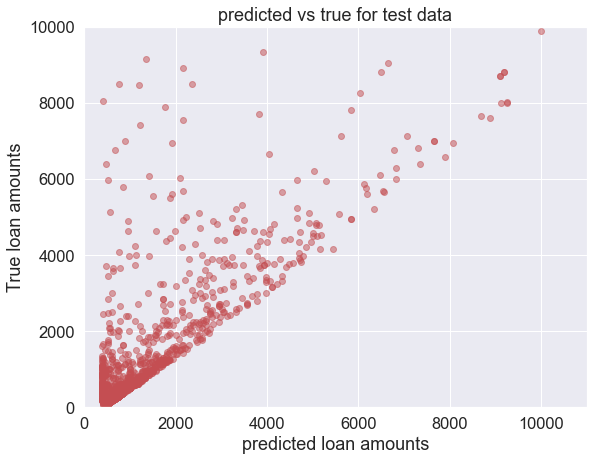

In [11]:
plt.figure(figsize=(9,7))
plt.scatter(y_pred_test, y_test, alpha=0.5, c='r')
plt.title('predicted vs true for test data')
plt.xlabel('predicted loan amounts')
plt.ylabel('True loan amounts')
axes = plt.gca()
axes.set_xlim([0,11000])
axes.set_ylim([0,10000])
plt.show();

Our model seems to be consistently under-predicting loan amounts (most of the dots seem to be above the line y=x).  We will try to improve this model using multivariate regression.


**Before we start looking for other explanatory features, it is important to note that interpretation of the results above is only valid if the assumptions of linear regression are not violated. Lets go through these assumptions now...**

<br>
<br> 
<br>

----